For each tweet, we have a set of given features.

id: Its an incremental number that is used to identify each tweet

timestamp: The time (in timestamp format) that the tweet was published

retweet_count: the actual number of retweets the tweet receive at the time of the of the crawl(only in training dataset)

user_verified: A boolean field indicating if the user has been verified by Twitter

user_statuses_count: The total number of tweets (statuses) the user has published

user_followers_count: The number of followers the user has

user_friends_count: The number of users that the user is following

user_mentions: The users that are mentioned within the tweet (e.g. "@someuser"). The entries are comma separated (e.g. "someuser,anotheruser"). If nothing is mentioned the field is empty (nan in pandas)

urls: The URLs that are included within the tweet. The entries are comma separated (e.g. "someurl.com,anotherurl.fr") If nothing is mentioned the field is empty (nan in pandas)

hashtags: The hashtags that are included within the tweet. The entries are comma separated (e.g. "hashtag1,hashtag2") If nothing is mentioned the field is empty (nan in pandas)

text: The text of the tweet as posted by the user

In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_absolute_error
from textblob import TextBlob
import fasttext

from verstack.stratified_continuous_split import scsplit 

import pickle 
import time

In [2]:
# Load the training data
train_data = pd.read_csv("data/train.csv")

X_train, X_test, y_train, y_test = scsplit(train_data, train_data['retweet_count'], 
                                           stratify=train_data['retweet_count'], train_size=0.8, test_size=0.2)

# Preprocessing

In [16]:
import os

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import RobustScaler

## Emoji

In [77]:
import emoji 

In [174]:
print(emoji.demojize(X_train['text'].iloc[2]))
print(X_train['text'].iloc[2])

In [36]:
import demoji
demoji.download_codes()

... OK (Got response in 0.34 seconds)
Writing emoji data to /Users/Jeremy/.demoji/codes.json ...
... OK


In [107]:
X_train['text'].iloc[22]

'That must of been hard to hear for the family but great to see he survived this deadly virus 👍'

In [52]:
demoji.findall(X_train['text'].iloc[22])

{'👍': 'thumbs up'}

In [102]:
len(X_train['text'].iloc[22])

94

In [80]:
from advertools import extract_emoji

In [97]:
emoji_summary = extract_emoji(X_train['text'].iloc[:10000])

In [98]:
emoji_summary['top_emoji'][:15]

[('😂', 249),
 ('😭', 127),
 ('🤣', 90),
 ('🇺🇸', 70),
 ('👇', 68),
 ('❤️', 66),
 ('🙏', 61),
 ('👏', 58),
 ('🤔', 57),
 ('💔', 42),
 ('🙄', 41),
 ('😷', 40),
 ('\U0001f97a', 32),
 ('⬇️', 28),
 ('🚨', 27)]

In [99]:
print("Number of emojis:", sum(emoji_summary['emoji_counts']))
print('Number of tweets containing an emoji:', sum(x > 0 for x in emoji_summary['emoji_counts']))

Number of emojis: 2874
Number of tweets containing an emoji: 1401


## Language

In [ ]:
PRETRAINED_MODEL_PATH = 'lid.176.bin'
lid_model = fasttext.load_model(PRETRAINED_MODEL_PATH)

In [ ]:
def detector(text):
    # return empty string if there is no tweet
    if text.isspace():
        return ""
    else:
        return lid_model.predict(text)[0][0].split("__label__")[1]

In [18]:
 class FeatureExtractor(object):

    def __init__(self):       
        
        self.scaler = RobustScaler()

        date_column = ['timestamp']
        boolean_column = ['user_verified']
        url_hashtag_column = ['urls', 'hashtags']
        numerical_columns = ['user_statuses_count', 'user_followers_count', 'user_friends_count']
        text_column = ['text']

        def timestamp(X):
            date = pd.to_datetime(X['timestamp'], unit='ms')
            return np.c_[date.dt.minute, date.dt.hour, date.dt.day, date.dt.month]

        timestamp_transformer = FunctionTransformer(timestamp, validate=False)

        def boolean(X):
            X['user_verified_int'] = X['user_verified'].astype(int)
            return X['user_verified_int'][:,np.newaxis]

        boolean_transformer = FunctionTransformer(boolean, validate=False)

        def url_hashtag(X):
            X["hashtags"].replace(np.nan, "", inplace = True)
            X["num_hashtags"]=X["hashtags"].apply(lambda x : len(x.split(", ")) if x!= "" else 0)
            X["urls"].replace(np.nan, "", inplace = True)
            X["num_urls"]=X["urls"].apply(lambda x : len(x.split(", ")) if x!= "" else 0)
            return np.c_[X["num_hashtags"][:,np.newaxis], X["num_urls"][:,np.newaxis]]

        url_hashtag_transformer = FunctionTransformer(url_hashtag, validate=False)

        def text(X):
            vectorizer = TfidfVectorizer(max_features=100, stop_words='english')
            X_text = vectorizer.fit_transform(X['text'])
            length = X['text'].str.len().to_numpy()
            language = X['text'].str.replace('\n', "").apply(detector)
            X['english'] = (language=='en').astype(int)

            return np.c_[X_text.toarray(), length[:,np.newaxis], X['english'][:,np.newaxis]]
        
        text_transformer = FunctionTransformer(text, validate=False)

        def sentiment(X):
            s = pd.Series(X['text']).apply(lambda x: TextBlob(x).sentiment)
            polarity = s.apply(lambda x: x[0])
            subjectivity = s.apply(lambda x: x[1])
            return np.c_[polarity, subjectivity]

        sentiment_transformer = FunctionTransformer(sentiment, validate=False)

        '''
        self.preprocessor = ColumnTransformer(
            transformers=[
                ('numerical', self.scaler, numerical_columns),
                ('date', make_pipeline(timestamp_transformer, self.scaler), date_column),
                ('bool', make_pipeline(boolean_transformer, self.scaler), boolean_column),    
                ('hashtag', make_pipeline(hashtag_transformer, self.scaler), hashtag_column),
                ('text', make_pipeline(text_transformer, self.scaler), text_column), 
                ])
        '''

        self.preprocessor = ColumnTransformer(
            transformers=[
                ('numerical', 'passthrough', numerical_columns),
                ('date', timestamp_transformer, date_column),
                ('bool', boolean_transformer, boolean_column),    
                ('hashtag', url_hashtag_transformer, url_hashtag_column),
                ('text', text_transformer, text_column), 
                ])

        pass

     #('sentiment', sentiment_transformer, text_column),  
    
    def fit(self, X_df):
        self.preprocessor.fit(X_df)
        pass
    
    def transform(self, X_df):
        X_encoded = X_df
        X_array = self.preprocessor.transform(X_encoded)
        return X_array
        

In [19]:
start = time.time()

Feature_Extractor = FeatureExtractor()
Feature_Extractor.fit(X_train)
X = Feature_Extractor.transform(X_train)

end = time.time()
print(round(end - start,2))

130.25


In [20]:
X.shape

(466043, 111)

In [21]:
Feature_Extractor.fit(X_test)
X_test_processed = Feature_Extractor.transform(X_test)

# SVR

In [11]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
X_reduced = pca.fit_transform(X)

In [13]:
X_reduced.shape

(466043, 10)

In [ ]:
reg = SVR(kernel='rbf')
reg.fit(X_reduced, y_train)

In [128]:
Feature_Extractor.fit(X_test)
X_test_transformed = Feature_Extractor.transform(X_test)
y_pred = reg.predict(X_test_transformed)
print("Prediction error:", mean_absolute_error(y_true=y_test, y_pred=y_pred))

Prediction error: 143.65990342970997


# Random Forest

In [ ]:
reg = RandomForestRegressor(random_state=0, n_estimators=20, max_depth=4, criterion='mae', n_jobs=2)
reg.fit(X, y_train)

In [ ]:
reg.feature_importances_

In [9]:
y_pred = reg.predict(X_test_processed)
print("Prediction error:", mean_absolute_error(y_true=y_test, y_pred=y_pred))

Prediction error: 262.073255732733


# Gradient Boosting Regressor

In [90]:
# tf–idf = term frequency–inverse document frequency
#vectorizer = TfidfVectorizer(max_features=100, stop_words='english')
#X_train = vectorizer.fit_transform(X_train['text'])
#X_test = vectorizer.transform(X_test['text'])

In [22]:
# Now we can train our model. Here we chose a Gradient Boosting Regressor and we set our loss function 
params = {'verbose': 1,
          'n_estimators': 50,
          'max_depth': 5,
          'min_samples_split': 5,
          'learning_rate': 0.1,
          'loss': 'lad'}  #least absolute deviation
reg = GradientBoostingRegressor(**params)
# We fit our model using the training data
reg.fit(X, y_train)

      Iter       Train Loss   Remaining Time 
         1         146.2364            9.09m
         2         146.0763            9.00m
         3         145.7609            9.18m
         4         145.5657            8.55m
         5         145.3764            8.06m
         6         145.1071            7.70m
         7         144.9030            7.48m
         8         144.6266            7.32m
         9         144.5426            7.23m
        10         144.4001            6.96m
        20         143.3910            5.01m
        30         142.7942            3.34m
        40         142.5315            1.65m
        50         142.1509            0.00s


GradientBoostingRegressor(loss='lad', max_depth=5, min_samples_split=5,
                          n_estimators=50, verbose=1)

In [23]:
# And then we predict the values for our testing set
y_pred = reg.predict(X_test_processed)
print("Prediction error:", mean_absolute_error(y_true=y_test, y_pred=y_pred))

Prediction error: 148.16680939340705


In [26]:
# Save to file in the current working directory
pkl_filename = "pickle_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(reg, file)

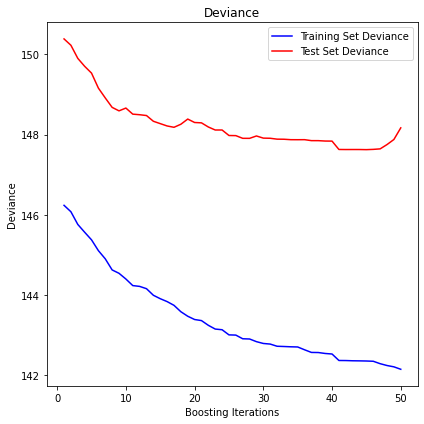

In [24]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test_processed)):
    test_score[i] = reg.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, reg.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.show()

## Prediction for the evaluating dataset

In [19]:
# Load from file
with open("pickle_model.pkl", 'rb') as file:
    model = pickle.load(file)

In [25]:
# Load the evaluation data
eval_data = pd.read_csv("data/evaluation.csv")

In [26]:
Feature_Extractor.fit(eval_data)
X_val = Feature_Extractor.transform(eval_data)

In [18]:
X_val.shape

(285334, 108)

In [27]:
# Predict the number of retweets for the evaluation dataset
y_pred = reg.predict(X_val)

In [28]:
# Dump the results into a file that follows the required Kaggle template
with open("gbr_predictions.txt", 'w') as f:
    writer = csv.writer(f)
    writer.writerow(["TweetID", "NoRetweets"])
    for index, prediction in enumerate(y_pred):
        writer.writerow([str(eval_data['id'].iloc[index]) , str(int(prediction))])

# XGBoost

In [6]:
from xgboost import XGBRegressor

In [22]:
params = {'learning_rate':0.1,  
          'objective': 'reg:linear', 
          'n_estimators': 150, 
          'max_depth': 5}

xgbReg = XGBRegressor(**params)

In [23]:
xgbReg.fit(X,y_train)

[11:36:20] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[11:42:05] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=150, n_jobs=0, num_parallel_tree=1,
             objective='reg:linear', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [24]:
y_pred = xgbReg.predict(X)
print("Prediction error on train set:", mean_absolute_error(y_true=y_train, y_pred=y_pred))

Prediction error on train set: 212.79391865597424


In [25]:
y_pred = xgbReg.predict(X_test_processed)
print("Prediction error:", mean_absolute_error(y_true=y_test, y_pred=y_pred))

Prediction error: 236.04159197627382
